# Connection

In [13]:
#libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib

In [14]:
#connection
#train data
train_url = 'https://drive.google.com/uc?id=1d_iE1bimIyceL0KelqNvQ0SZqjscYoA8'
train = pd.read_csv(train_url)

#test data
test_url = 'https://drive.google.com/uc?id=1GOvJF4omhWEL_csv3tcLiPDLPi-vNro2'
test = pd.read_csv(test_url)

# EDA


In [15]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
train.info()
# data types are fine
# nulls in AGE, CABIN and EMBARKED columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Survival rate by Sex:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64




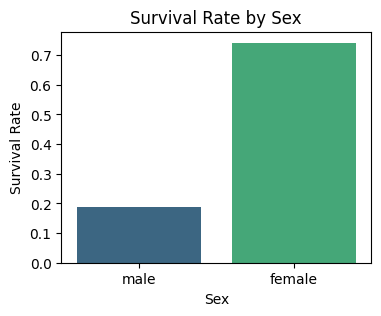

In [17]:
# survival rates by Sex
survival_by_sex = train.groupby('Sex')['Survived'].mean()
print("Survival rate by Sex:")
print(survival_by_sex)
print("\n")

# plot
plt.figure(figsize=(4, 3))
sns.barplot(x='Sex', y='Survived', data=train, ci=None, palette='viridis')
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')
plt.show()

Survival rate by Passenger Class:
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64




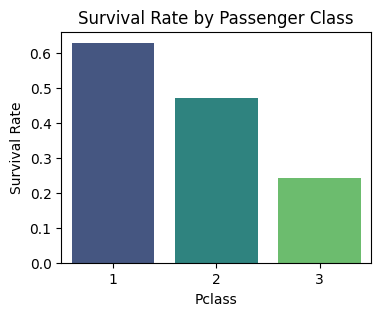

In [18]:
# survival rates by Passenger Class
survival_by_pclass = train.groupby('Pclass')['Survived'].mean()
print("Survival rate by Passenger Class:")
print(survival_by_pclass)
print("\n")

# plot
plt.figure(figsize=(4, 3))
sns.barplot(x='Pclass', y='Survived', data=train, ci=None, palette='viridis')
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

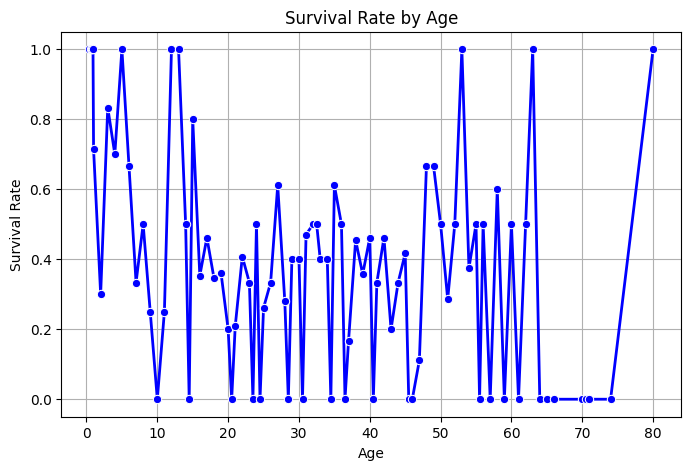

In [19]:
# survival rates by Age
survival_by_age = train.groupby('Age')['Survived'].mean().sort_values(ascending=False)

#plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=survival_by_age.index, y=survival_by_age.values, marker='o', color='b', linewidth=2)
plt.title('Survival Rate by Age')
plt.xlabel('Age')
plt.ylabel('Survival Rate')
plt.grid(True)
plt.show()

# Context for Data Handling

- **Cabin Letters and Deck Levels**:
  - **A/B**: High decks, primarily first-class, with easier lifeboat access.
  - **C/D**: Mid-level decks, mix of first/second-class.
  - **E/F**: Lower decks, mixed classes, more difficult access.
  - **G**: Lowest deck, mostly third-class, hardest access.
  - **NaN**: Unrecorded cabins, typically third-class or general areas.

- **Zero Fares**: Likely indicate complimentary or sponsored travel:
  - **Third-Class "LINE" Tickets**: Possibly crew or complimentary passengers.
  - **First-Class Passengers**: Some, like Titanic architect Mr. Andrews, may have traveled free due to business or personal ties.
  - **Second-Class Passengers**: Group or sponsored fares under one ticket.

- **Passenger Specifics**:
  - **Mrs. George Nelson Stone** and her maid, **Miss Amelie Icard** (both with NaN in the Embarked column), boarded at **Southampton** according to the Encyclopedia Titanica.

# Data Preprocessing

In [20]:
def preprocess_data(data):

    # Fare NaNs handling by filling with avg fare for class
    average_fares = data.groupby('Pclass')['Fare'].mean().reset_index()
    average_fares.columns = ['Pclass', 'AvgFare']
    data = data.merge(average_fares, on='Pclass', how='left')
    data['Fare'] = data['Fare'].fillna(data['AvgFare'])
    data['Fare'] = data.apply(lambda row: row['AvgFare'] if row['Fare'] == 0 else row['Fare'], axis=1)

    # dropping 'AvgFare' column as it's no longer needed
    data.drop(columns=['AvgFare'], inplace=True)

    # imputing missing Age values using KNN
    imputer = KNNImputer(n_neighbors=3)
    data_imputed = imputer.fit_transform(data[['Age']])
    data['Age'] = data_imputed

    # filling missing 'Embarked' values with mode ('S') according to the context
    data['Embarked'] = data['Embarked'].fillna('S')

    # handling Cabin values: fill missing values with 'N' and extract first letter from existing values
    data['Cabin'] = data['Cabin'].fillna('N')
    data['Cabin'] = data['Cabin'].apply(lambda x: x[0])

    # calculating family size
    data['Family_Size'] = data['SibSp'] + data['Parch']

    # extracting title from 'Name' and categorize titles
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

    title_categories = {
        'Common': ['Mr', 'Mrs', 'Miss', 'Master', 'Mme', 'Ms', 'Mlle'],
        'Noble': ['Don', 'Lady', 'Sir', 'Countess', 'Jonkheer'],
        'Religious': ['Rev', 'Dr'],
        'Military': ['Major', 'Col', 'Capt']
    }

    title_to_category = {title: category for category, titles in title_categories.items() for title in titles}
    data['Title_Category'] = data['Title'].map(title_to_category).fillna('Common')

    # creating age groups
    age_bins = [-1, 5, 14, 17, 30, 60, float('inf')]
    age_labels = ['Baby', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
    data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)

    # creating an indicator for traveling alone
    data['Alone'] = data['Family_Size'] == 0

    # categorizing fare into bins
    fare_bins = [-1, 4, 15, 25, 50, 100, 250, float('inf')]
    fare_labels = ['Very Low', 'Low', 'Moderate', 'Medium', 'High', 'Very High', 'Luxury']
    data['Fare_Category'] = pd.cut(data['Fare'], bins=fare_bins, labels=fare_labels)

    # interacting feature between Pclass and Fare Category
    data['Pclass_Fare_Category'] = data['Pclass'].astype(str) + "_" + data['Fare_Category'].astype(str)

    # one-hot encoding for categorical features
    data = pd.get_dummies(data, columns=['Title_Category', 'Age_Group', 'Fare_Category', 'Pclass_Fare_Category', 'Sex', 'Embarked'], drop_first=True)

    # dropping unnecessary columns
    data = data.drop(columns=['Name', 'Ticket', 'Cabin', 'Title'])

    return data


train_clean = preprocess_data(train)
test_clean = preprocess_data(test)


# Model

In [21]:
# Define features and target variable
X = train_clean.drop(columns=['Survived', 'PassengerId'])
y = train_clean['Survived']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grids for base models
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gb_params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 0.9, 1.0],
}

# Set up and tune the base models using GridSearchCV
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy', n_jobs=-1)

# Fit and retrieve the best estimators for both models
rf_grid_search.fit(X_train_scaled, y_train)
gb_grid_search.fit(X_train_scaled, y_train)

best_rf = rf_grid_search.best_estimator_
best_gb = gb_grid_search.best_estimator_

# Apply BaggingClassifier to the best Gradient Boosting model for additional generalization
bagging_gb = BaggingClassifier(estimator=best_gb, n_estimators=10, random_state=42)

# Define the simplified stacking ensemble with L2-regularized Logistic Regression as the meta-model
stacking_classifier = StackingClassifier(
    estimators=[('rf', best_rf), ('bagged_gb', bagging_gb)],
    final_estimator=LogisticRegression(penalty='l2', C=1.0, random_state=42),
    cv=5
)

# Fit the stacking model on the scaled training data
stacking_classifier.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate
y_pred = stacking_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Optionally save the model
joblib.dump(stacking_classifier, 'stacking_model.joblib')
print("Model saved as 'stacking_model.joblib'")

Accuracy: 0.8268156424581006
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       105
           1       0.84      0.72      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179

Confusion Matrix:
 [[95 10]
 [21 53]]
Model saved as 'stacking_model.joblib'


In [22]:
#test dataset

# Preprocess the test data: Drop 'PassengerId' and align columns to match the training data
X_test = test_clean.drop(columns=['PassengerId'])  # Drop columns that are not features

# Align test data with training data columns
X_train = train_clean.drop(columns=['Survived', 'PassengerId'])
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)  # Fill missing columns with 0

# Load the scaler used during training
scaler = StandardScaler()
scaler.fit(X_train)  # Fit the scaler on the training data
X_test_scaled = scaler.transform(X_test_aligned)  # Scale the aligned test data

# Load the trained stacking ensemble model
loaded_model = joblib.load('stacking_model.joblib')

# Make predictions on the aligned and scaled test data
y_test_pred = loaded_model.predict(X_test_scaled)

# Save predictions to a CSV file
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_test_pred})
output.to_csv('submission.csv', index=False)
print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
